<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию 14 "Разметка текста" 8.11.2020

Борис Грибовский xinu@yandex.ru

## Подготовка

In [ ]:
!pip install pymorphy2 # установка лемматизатора pymorphy2

Исправленные договора

In [ ]:
!wget https://xland.ru/uai/hw14/contracts432_fixed.zip

--2020-11-13 08:07:59--  https://xland.ru/uai/hw14/contracts432_fixed.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6488895 (6.2M) [application/zip]
Saving to: ‘contracts432_fixed.zip’

contracts432_fixed. 100%[===================>]   6.19M  5.81MB/s    in 1.1s    

2020-11-13 08:08:01 (5.81 MB/s) - ‘contracts432_fixed.zip’ saved [6488895/6488895]



In [ ]:
!unzip -q contracts432_fixed.zip

### Функции

In [ ]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети 
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D 
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose, Lambda, LSTM, Flatten, GlobalAveragePooling1D
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы 
from tensorflow.keras import utils # Импортируем для работы с категориальными данными 
from google.colab import files # Импортируем для работы с файлами
import matplotlib.pyplot as plt # Импортируем для отрисовки графиков
from gensim.models import word2vec # Импортируем gensim 
import os # Импортируем для работы с файловой системой
import pandas as pd # И мпортируем для работы с DataFrame
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени 
import random
from sys import getsizeof

class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='loss on train')
        plt.plot(ep, self.history['val_loss'], label='loss on test')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы
 
  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<6: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 6] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длину текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

def dice_coef(y_true, y_pred):
    return K.mean(y_true*y_pred + (1 - y_true)*(1 - y_pred))

# Функция для создания линейной cnonv1d-сети
def create_Conv1d(xLen, embeddingSize): 
  text_input_layer = Input((xLen,embeddingSize)) 
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_input_layer)
  text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_layer)
  text_layer = Conv1D(16, 3,padding='same', activation='relu')(text_layer) 
  text_layer = Conv1D(yTrainGENSIM.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)
  model = Model(text_input_layer, text_layer)
  model.compile(optimizer=Adadelta(),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
  return model

# Функция для создания PSPnet-сети
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

#Функция для создания сети UNET 
def create_unet(k=1, num_classes=6, input_shape=(None, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape) 

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling1D()(block_2_out)

    # Block 3
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # x = block_3_out
    x = MaxPooling1D()(block_3_out)

    # Block 4
    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(x, 256, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

# Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, length, value):
  total=0
  tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
  for j in range(6): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 
    print("Сеть распознала категорию '%s' на %.2f%%" % (tags[j], 100*correct/(len(tagI)*length)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность %.2f%%" % (total/6))


### Классы Трансформера

Взяты [отсюда](https://github.com/keras-team/keras-io/blob/master/examples/nlp/text_classification_with_transformer.py)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Implement multi head self attention as a Keras layer
"""

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions



### Подготовка данных

In [ ]:
%%time
# directory = '/content/drive/My Drive/Базы/Договора432/'
directory = '/content/Договора432/'
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
    txt = readText(directory + filename) # Читаем текст договора
    if txt != '': # Если текст не пустой
        agreements.append(readText(directory + filename))
words = [] # Здесь будут храниться все договора в виде списка слов
print("Токенизация...")
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
    words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

modelGENSIM = word2vec.Word2Vec(xTrain, size=embeddingSize, window=10, min_count=1, workers=10, iter=10)
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

Токенизация...
На преобразование ушло: 145.28 с.
Индексы тегов: [ 12 348  22  28 116 273  13 349  23  29 117 274]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 4min 32s, sys: 7.39 s, total: 4min 40s
Wall time: 3min 43s


In [ ]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 7):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 4322, </s1>: 4322
<s2>: 204, </s2>: 204
<s3>: 2490, </s3>: 2490
<s4>: 2095, </s4>: 2095
<s5>: 691, </s5>: 691
<s6>: 279, </s6>: 279


### Conv1D

In [ ]:
model_conv1d = create_Conv1d(xLen, embeddingSize) # Создаем простую сеть
model_conv1d.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 300)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 16)           14416     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 16)           784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 256, 6)            294       
Total params: 16,278
Trainable params: 16,278
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_conv1d.fit(xTrainGENSIM, yTrainGENSIM, epochs=20, batch_size=200, validation_split = 0.2)

### PSPnet

In [ ]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 256, 64)      57664       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64)      256         conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
history = model_b_PSPnet.fit(xTrainGENSIM, yTrainGENSIM, epochs=20, batch_size=64, validation_split = 0.2)

In [ ]:
model_b_PSPnet = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

In [ ]:
history = model_b_PSPnet.fit(xTrainGENSIM, yTrainGENSIM, epochs=60, batch_size=64, validation_split = 0.2)

### U-net

In [ ]:
model_b_UNET = create_unet(k=2, input_shape=(None, embeddingSize))
model_b_UNET.summary()
lh = LearnHistory()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, None, 128)    115328      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, None, 128)    512         conv1d_17[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, 128)    0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

Epoch 1/20
171/171 [==============================] - 11s 66ms/step - loss: 0.5128 - dice_coef: 0.8319 - val_loss: 2.9426 - val_dice_coef: 0.7569
Epoch 2/20
171/171 [==============================] - 11s 62ms/step - loss: 0.3124 - dice_coef: 0.8843 - val_loss: 1.0298 - val_dice_coef: 0.8236
Epoch 3/20
171/171 [==============================] - 10s 61ms/step - loss: 0.2543 - dice_coef: 0.8999 - val_loss: 1.0232 - val_dice_coef: 0.8664
Epoch 4/20
171/171 [==============================] - 10s 61ms/step - loss: 0.2261 - dice_coef: 0.9095 - val_loss: 1.3907 - val_dice_coef: 0.8563
Epoch 5/20
171/171 [==============================] - 10s 61ms/step - loss: 0.2275 - dice_coef: 0.9116 - val_loss: 1.2712 - val_dice_coef: 0.8455
Epoch 6/20
171/171 [==============================] - 10s 61ms/step - loss: 0.2254 - dice_coef: 0.9125 - val_loss: 1.1322 - val_dice_coef: 0.8671
Epoch 7/20
171/171 [==============================] - 10s 61ms/step - loss: 0.1992 - dice_coef: 0.9231 - val_loss: 1.4015 - 

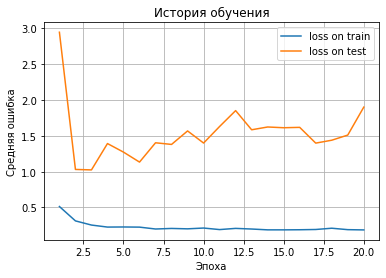

In [ ]:
history = model_b_UNET.fit(xTrainGENSIM, yTrainGENSIM, epochs=20, batch_size=64, validation_split = 0.2)
lh.append(history)
lh.plot()

### Testing

In [ ]:
model = model_b_UNET 

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest)
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xDataTest)
xTest = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step)
modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)
pred = model.predict(xTestGENSIM)
recognizeSet(yTestGENSIM, pred, xLen, 0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Сеть распознала категорию 'S1' на 36.87%
Сеть распознала категорию 'S2' на 97.86%
Сеть распознала категорию 'S3' на 89.74%
Сеть распознала категорию 'S4' на 51.43%
Сеть распознала категорию 'S5' на 93.61%
Сеть распознала категорию 'S6' на 98.50%
Cредняя точность 78.00%


In [ ]:
recognizeSet(yTestGENSIM, pred, xLen, 0.5)

Сеть распознала категорию 'S1' на 36.75%
Сеть распознала категорию 'S2' на 97.86%
Сеть распознала категорию 'S3' на 89.65%
Сеть распознала категорию 'S4' на 29.69%
Сеть распознала категорию 'S5' на 93.61%
Сеть распознала категорию 'S6' на 98.50%
Cредняя точность 74.34%


In [ ]:
recognizeSet(yTestGENSIM, pred, xLen, 0.999)

Сеть распознала категорию 'S1' на 57.39%
Сеть распознала категорию 'S2' на 97.86%
Сеть распознала категорию 'S3' на 89.74%
Сеть распознала категорию 'S4' на 89.76%
Сеть распознала категорию 'S5' на 93.61%
Сеть распознала категорию 'S6' на 98.50%
Cредняя точность 87.81%


Обнаружен странный эффект - точность повышается, если задать порог в recognizeSet() близким к единице (см. выше). Хотя по логике этот порог надо задавать равным 0.5

## LIGHT 

### Сделайте свою собственную архитектуру 
и запустите, оцените точность на проверочной выборке


Попробуем применить архитектуру Трансформер с собственным эмбеддингом.

In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
pageSize = xLen
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

5681


((13263, 256), (13263, 256, 6))

In [ ]:
num_heads = 3  # Number of attention heads
ff_dim = 600  # Hidden layer size in feed forward network inside transformer

inp = Input(shape=(pageSize,))
x = TokenAndPositionEmbedding(pageSize, vocSize, embeddingSize)(inp)
x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x)
# x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x) # Можно добавлять блоки энкодера
# x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x)
x = Dense(200, activation="relu")(x)
x = Dropout(0.1)(x)
out = Dense(num_classes, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer=Adam(0.0025), loss='categorical_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
token_and_position_embedding (None, 256, 300)          1781100   
_________________________________________________________________
transformer_block_1 (Transfo (None, 256, 300)          723300    
_________________________________________________________________
dense_14 (Dense)             (None, 256, 200)          60200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 200)          0         
_________________________________________________________________
dense_15 (Dense)             (None, 256, 6)            1206      
Total params: 2,565,806
Trainable params: 2,565,806
Non-trainable params: 0
____________________________________________

Epoch 1/30
1194/1194 [==============================] - 35s 30ms/step - loss: 0.5844 - dice_coef: 0.8015 - val_loss: 0.5238 - val_dice_coef: 0.8379
Epoch 2/30
1194/1194 [==============================] - 35s 29ms/step - loss: 0.3927 - dice_coef: 0.8591 - val_loss: 0.5329 - val_dice_coef: 0.8578
Epoch 3/30
1194/1194 [==============================] - 35s 29ms/step - loss: 0.3221 - dice_coef: 0.8782 - val_loss: 0.5855 - val_dice_coef: 0.8663
Epoch 4/30
1194/1194 [==============================] - 35s 29ms/step - loss: 0.2836 - dice_coef: 0.8895 - val_loss: 0.6413 - val_dice_coef: 0.8669
Epoch 5/30
1194/1194 [==============================] - 35s 29ms/step - loss: 0.2590 - dice_coef: 0.8981 - val_loss: 0.7336 - val_dice_coef: 0.8713
Epoch 6/30
1194/1194 [==============================] - 35s 29ms/step - loss: 0.2382 - dice_coef: 0.9047 - val_loss: 0.7665 - val_dice_coef: 0.8750
Epoch 7/30
1194/1194 [==============================] - 36s 30ms/step - loss: 0.2240 - dice_coef: 0.9109 - val_l

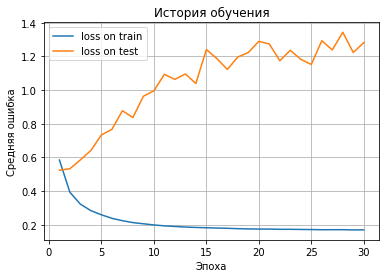

In [ ]:
history = model.fit(x_train, y_train, epochs=30, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((866, 256), (866, 256, 6))

In [ ]:
score = model.evaluate(x_test, y_test)
score

28/28 [==============================] - 0s 10ms/step - loss: 1.8508 - dice_coef: 0.8707


[1.850821852684021, 0.8706525564193726]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 64.10%
Сеть распознала категорию 'S2' на 98.78%
Сеть распознала категорию 'S3' на 84.95%
Сеть распознала категорию 'S4' на 87.72%
Сеть распознала категорию 'S5' на 94.25%
Сеть распознала категорию 'S6' на 98.74%
Cредняя точность 88.09%


### Возьмите “лучшую” архитектуру 
и проведите несколько экспериментов, меняя гиперпараметры выбранной архитектуры.


В качестве эксперимента попробуем архитектуру PSPnet с эмбеддингом. 

Соберем модель, состоящую из слоя эмбеддинга и готовой модели PSPnet:

In [ ]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 256, 300)          1704300   
_________________________________________________________________
functional_5 (Functional)    (None, 256, 6)            6895622   
Total params: 8,599,922
Trainable params: 8,597,874
Non-trainable params: 2,048
_________________________________________________________________


Epoch 1/10
1194/1194 [==============================] - 40s 33ms/step - loss: 0.1587 - dice_coef: 0.9076 - val_loss: 0.1772 - val_dice_coef: 0.9218
Epoch 2/10
1194/1194 [==============================] - 40s 33ms/step - loss: 0.0683 - dice_coef: 0.9614 - val_loss: 0.2290 - val_dice_coef: 0.9342
Epoch 3/10
1194/1194 [==============================] - 40s 33ms/step - loss: 0.0415 - dice_coef: 0.9770 - val_loss: 0.2437 - val_dice_coef: 0.9346
Epoch 4/10
1194/1194 [==============================] - 39s 33ms/step - loss: 0.0292 - dice_coef: 0.9838 - val_loss: 0.2756 - val_dice_coef: 0.9399
Epoch 5/10
1194/1194 [==============================] - 39s 33ms/step - loss: 0.0215 - dice_coef: 0.9881 - val_loss: 0.3336 - val_dice_coef: 0.9408
Epoch 6/10
1194/1194 [==============================] - 39s 33ms/step - loss: 0.0175 - dice_coef: 0.9903 - val_loss: 0.3712 - val_dice_coef: 0.9415
Epoch 7/10
1194/1194 [==============================] - 40s 33ms/step - loss: 0.0147 - dice_coef: 0.9919 - val_l

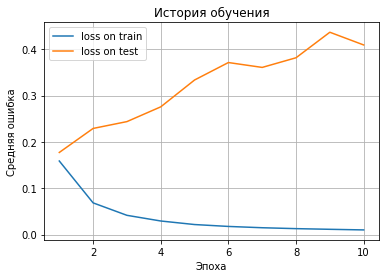

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
score = model.evaluate(x_test, y_test)
score

28/28 [==============================] - 0s 12ms/step - loss: 0.4917 - dice_coef: 0.9280


[0.491712361574173, 0.9280405640602112]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.9)

Сеть распознала категорию 'S1' на 81.86%
Сеть распознала категорию 'S2' на 99.15%
Сеть распознала категорию 'S3' на 91.29%
Сеть распознала категорию 'S4' на 91.67%
Сеть распознала категорию 'S5' на 95.61%
Сеть распознала категорию 'S6' на 99.71%
Cредняя точность 93.21%


### ВЫВОДЫ

Были опробованы архитектуры трансформера в минимальной конфигурации (1 блок энкодера, 3 головы)
и сеть PSPnet-256 со встроенным эмбеддингом.

Трансформер показал точность 88% на тестовой выборке, PSPnet - 93%.

Точность измерялась функцией recognizeSet с порогом 0.9, причем в обоих случаях этот показатель совпал (с точностью 1%) с показателем, выдаваемым моей метрикой dice_coef.

## PRO

### Вариант 1

Используйте другие методы обработки текста (которых не было в занятии, например, embedding слой), поменяйте параметры UNET с занятия и добейтесь с ними точности 85%.


Данный показатель - 85% был превышен в задании LIGHT. Трансформер выдал 88%, PSPnet - 93%

### Вариант 2

Реализуйте сегментацию на расширенной выборке договоров и добейтесь точности не менее 88%.


In [ ]:
!wget https://xland.ru/uai/hw14/contracts1000.zip

--2020-11-13 08:21:31--  https://xland.ru/uai/hw14/contracts1000.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3767038 (3.6M) [application/zip]
Saving to: ‘contracts1000.zip’

contracts1000.zip   100%[===================>]   3.59M  3.85MB/s    in 0.9s    

2020-11-13 08:21:33 (3.85 MB/s) - ‘contracts1000.zip’ saved [3767038/3767038]



In [ ]:
!unzip -q contracts1000.zip

error:  cannot create Договора1000/Типовой договор на перевозку автотранспортными предприятиями или организациями зерна (сахарной свеклы), сдаваемого колхозами, совхозами и другими организациями государству.txt
        File name too long
error:  cannot create Договора1000/Договор страхования ответственности производителя или исполнителя за причинение вреда потребителю вследствие недостатков товара, работы, услуги.txt
        File name too long
error:  cannot create Договора1000/Договор страхования имущества (страхователь - физическое или юридическое лицо_ в пользу выгодоприобретателя - физического или юридического лица_ сострахование).txt
        File name too long
error:  cannot create Договора1000/Договор с пользователем на передачу и информационное сопровождение программного продукта (информационных, справочных, нормативных систем).txt
        File name too long
error:  cannot create Договора1000/Договор страхования имущества (страхователь - физическое или юридическое лицо, в пользу

10 договоров имели слишком длинные названия, отброшены.

In [ ]:
%%time
directory = '/content/Договора1000/'
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
    txt = readText(directory + filename) # Читаем текст договора
    if txt != '': # Если текст не пустой
        agreements.append(readText(directory + filename))
words = [] # Здесь будут храниться все договора в виде списка слов
print("Токенизация...")
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
    words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

# modelGENSIM = word2vec.Word2Vec(xTrain, size=embeddingSize, window=10, min_count=1, workers=10, iter=10)
# xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

Токенизация...
На преобразование ушло: 310.09 с.
Индексы тегов: [ 12 396  26  29 132 265  14 401  30  38 142 281]
CPU times: user 5min 2s, sys: 14.5 s, total: 5min 16s
Wall time: 5min 17s


In [ ]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 7):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 8608, </s1>: 7930
<s2>: 357, </s2>: 350
<s3>: 4134, </s3>: 3818
<s4>: 3832, </s4>: 3422
<s5>: 1205, </s5>: 1082
<s6>: 618, </s6>: 568


**ЗАМЕЧАНИЯ**

1.   Пришлось отказаться от внешнего word2vec - он порождает слишком большие массивы, не влезающие в память. Будем использовать стандартные слои Embedding.
2.   Проверка показала плохую разметку - сильную нехватку закрывающихся тэгов (порядка 10%) - это приведет к неверному формированию yData и плохим/некорректным результатам работы нейронки.




#### PSPNet-256

In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
# pageSize = xLen
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

8923


((27410, 256), (27410, 256, 6))

In [ ]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 300)          2676900   
_________________________________________________________________
functional_1 (Functional)    (None, 256, 6)            6895622   
Total params: 9,572,522
Trainable params: 9,570,474
Non-trainable params: 2,048
_________________________________________________________________


Epoch 1/10
2467/2467 [==============================] - 105s 43ms/step - loss: 0.2470 - dice_coef: 0.8522 - val_loss: 0.3141 - val_dice_coef: 0.8628
Epoch 2/10
2467/2467 [==============================] - 104s 42ms/step - loss: 0.1359 - dice_coef: 0.9209 - val_loss: 0.3501 - val_dice_coef: 0.8704
Epoch 3/10
2467/2467 [==============================] - 108s 44ms/step - loss: 0.0877 - dice_coef: 0.9496 - val_loss: 0.3958 - val_dice_coef: 0.8698
Epoch 4/10
2467/2467 [==============================] - 104s 42ms/step - loss: 0.0636 - dice_coef: 0.9640 - val_loss: 0.4568 - val_dice_coef: 0.8855
Epoch 5/10
2467/2467 [==============================] - 104s 42ms/step - loss: 0.0483 - dice_coef: 0.9728 - val_loss: 0.5045 - val_dice_coef: 0.8881
Epoch 6/10
2467/2467 [==============================] - 104s 42ms/step - loss: 0.0391 - dice_coef: 0.9781 - val_loss: 0.5142 - val_dice_coef: 0.8826
Epoch 7/10
2467/2467 [==============================] - 104s 42ms/step - loss: 0.0325 - dice_coef: 0.9818 

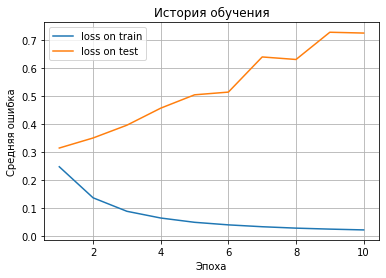

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((829, 256), (829, 256, 6))

In [ ]:
score = model.evaluate(x_test, y_test)
score

26/26 [==============================] - 0s 18ms/step - loss: 0.6893 - dice_coef: 0.8907


[0.6892638206481934, 0.8906542062759399]

In [ ]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.5)

Сеть распознала категорию 'S1' на 74.94%
Сеть распознала категорию 'S2' на 99.41%
Сеть распознала категорию 'S3' на 86.13%
Сеть распознала категорию 'S4' на 84.43%
Сеть распознала категорию 'S5' на 92.54%
Сеть распознала категорию 'S6' на 98.96%
Cредняя точность 89.40%


#### ВЫВОДЫ

Удалось достичь точности 89.4 % по метрике recognizeSet(). Моя метрика (dice_coef) показала те же 89%

Заметил странность - во время обучения val_loss увеличивается, хотя метрика dice_coef показывает улучшение точности. Возможно val_loss вычисляется некорректно (например из-за использования validation_split на перекрывающихся последовательностях вместо validation_data) но поскольку данные dice_coef хорошо согласуются с независимой оценкой recognizeSet на тестовой выборке, я думаю им можно доверять. 

## Ultra PRO


Поскольку разметка базы резюме или текстов писателей - как предложено в условии - задача совершенно неподъемная в разумные сроки, я взял роман "Мастер и Маргарита" М. Булгакова. Это "роман в романе", он содержит внутри себя роман о Понтии Пилате, написанный Мастером. Я разметил текст тэгами <s1> выделив "внутренний" роман. Задача сети - разделить текст (а точнее каждое слово) на 2 класса - основной текст и внутренний роман.  

In [ ]:
!wget https://xland.ru/uai/hw13/master_i_margarita_markup.txt

--2020-11-10 07:39:11--  https://xland.ru/uai/hw13/master_i_margarita_markup.txt
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1378427 (1.3M) [text/plain]
Saving to: ‘master_i_margarita_markup.txt’

master_i_margarita_ 100%[===================>]   1.31M  --.-KB/s    in 0.03s   

2020-11-10 07:39:11 (45.1 MB/s) - ‘master_i_margarita_markup.txt’ saved [1378427/1378427]



In [ ]:
text = readText('master_i_margarita_markup.txt')

In [ ]:

print("Токенизация...")
curTime = time.time() # Засечем текущее время
words = text2Words(text) # Преобразуем 
print('На преобразование ушло: %.2f сек' % (time.time() - curTime))

Токенизация...
На преобразование ушло: 32.97 сек


In [ ]:
len(words)

114316

In [ ]:
tokenizer_mm = Tokenizer(lower=True, filters='', char_level=False)

tokenizer_mm.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer_mm.word_index.items(): #Преобразуем полученный список 
  clean_voc[item[0]] = item[1] # В словарь, меняя местами элементы полученного кортежа 

In [ ]:
len(tokenizer_mm.index_word.items())

11118

In [ ]:
for i in range(1, 2):
    print(tokenizer_mm.word_index['<s%d>' % i], tokenizer_mm.word_index['</s%d>' % i])

3790 3928


In [ ]:
count1, count2 = 0, 0
for w in words:
    if w == '<s1>':
        count1 += 1
    if w == '</s1>':
        count2 += 1
print(count1, count2)

3 3


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
tok_mm = tokenizer_mm.texts_to_sequences([words]) # Обучающие тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", words[2000:2020])
print("Он же в виде последовательности индексов: ", tok_mm[0][2000:2020], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ['доказательство', 'существование', 'бог', 'быть', 'не', 'мочь', 'браво', 'вскричать', 'иностранец', 'браво', 'вы', 'полностью', 'повторить', 'мысль', 'беспокойный', 'старик', 'иммануил', 'по', 'этот', 'повод']
Он же в виде последовательности индексов:  [928, 3740, 182, 9, 4, 58, 1962, 334, 197, 1962, 15, 1963, 822, 175, 1218, 1749, 6687, 22, 24, 1571] 



In [ ]:
len(tok_mm[0])

114316

In [ ]:
id1 = tokenizer_mm.word_index['<s1>']
id0 = tokenizer_mm.word_index['</s1>']
x, y = [], []
state = 0 
for i, id in enumerate(tok_mm[0]):
    if id == id1:
        print("found open " + str(i))
        state = 1
    elif id == id0:
        print("found close " + str(i))
        state = 0
    else:
        x.append(id)
        y.append(state)
xData = np.array(x)
yData = np.array(y)
xData.shape, yData.shape


found open 3650
found close 10484
found open 48136
found close 51838
found open 85252
found close 94645


((114310,), (114310,))

In [ ]:
yData[3640:3660]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Смысл дальнейшего: разделим роман на "страницы" по 128 слов и рассыплем их случайно на 2 кучки - тренировочную и тестовую. 100 страниц на тест, 793 - на обучение.

In [ ]:
pageSize = 128
pagesNum = xData.shape[0] // pageSize
xData = xData[:pageSize*pagesNum]
yData = yData[:pageSize*pagesNum]

xData.resize(pagesNum, pageSize)
yData.resize(pagesNum, pageSize)
xData.shape, yData.shape

((893, 128), (893, 128))

In [ ]:
ind = np.arange(pagesNum)
np.random.shuffle(ind)

In [ ]:
xTrain = xData[ind[:-100]]
yTrain = yData[ind[:-100]]
xTest = xData[ind[-100:]]
yTest = yData[ind[-100:]]

In [ ]:
xTest.shape, xTrain.shape

((100, 128), (793, 128))

In [ ]:
embeddingSize = 256
vocSize = len(tokenizer_mm.index_word.items())
print(vocSize)

11118


### U-net

будем использовать собственный эмбеддинг.

In [ ]:
inp = Input(shape=(pageSize))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_unet(k=1, num_classes=1, input_shape=(pageSize, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
embedding_45 (Embedding)     (None, 128, 256)          2846208   
_________________________________________________________________
functional_79 (Functional)   (None, 128, 1)            3731329   
Total params: 6,577,537
Trainable params: 6,569,473
Non-trainable params: 8,064
_________________________________________________________________


Epoch 1/20
72/72 [==============================] - 18s 256ms/step - loss: 0.3623 - dice_coef: 0.7716 - val_loss: 0.5304 - val_dice_coef: 0.8368
Epoch 2/20
72/72 [==============================] - 18s 248ms/step - loss: 0.1870 - dice_coef: 0.8860 - val_loss: 1.0838 - val_dice_coef: 0.8624
Epoch 3/20
72/72 [==============================] - 18s 248ms/step - loss: 0.1398 - dice_coef: 0.9070 - val_loss: 0.6753 - val_dice_coef: 0.8895
Epoch 4/20
72/72 [==============================] - 18s 248ms/step - loss: 0.1397 - dice_coef: 0.9120 - val_loss: 1.4413 - val_dice_coef: 0.8686
Epoch 5/20
72/72 [==============================] - 18s 248ms/step - loss: 0.0668 - dice_coef: 0.9569 - val_loss: 0.6419 - val_dice_coef: 0.8933
Epoch 6/20
72/72 [==============================] - 18s 248ms/step - loss: 0.0357 - dice_coef: 0.9743 - val_loss: 0.4486 - val_dice_coef: 0.8983
Epoch 7/20
72/72 [==============================] - 18s 249ms/step - loss: 0.0592 - dice_coef: 0.9710 - val_loss: 1.2308 - val_dic

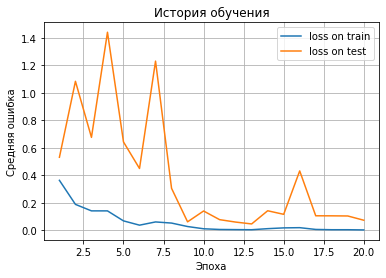

In [ ]:
history = model.fit(xTrain, yTrain, epochs=20, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
score = model.evaluate(xTest, yTest)

4/4 [==============================] - 0s 88ms/step - loss: 0.1173 - dice_coef: 0.9712


In [ ]:
score

[0.11725915223360062, 0.9711576104164124]

In [ ]:
pred = model.predict(xTest)

In [ ]:
pred.shape

(100, 128, 1)

In [ ]:
# Подсчитаем, какая часть слов внутреннего романа правильно распознана
count1, count2 = 0, 0
for i in range(100):
    for j in range(pageSize):
        if yTest[i, j] == 1:
            count1 += 1
            if pred[i, j, 0] > 0.5:
                count2 += 1
print(count1, count2, 'correct: %.4f' % (count2/count1))
# Подсчитаем, какая часть основного романа неправильно распознана как внутренний
count1, count2 = 0, 0
for i in range(100):
    for j in range(pageSize):
        if yTest[i, j] == 0:
            count1 += 1
            if pred[i, j, 0] > 0.5:
                count2 += 1
print(count1, count2, 'errors: %.4f' % (count2/count1))


2427 2134 correct: 0.8793
10373 117 errors: 0.0113


### Трансформер

Попробовал применить архитектуру "Трансформер". Взял простейший вариант с 1 блоком энкодера.

In [ ]:

num_heads = 4  # Number of attention heads
ff_dim = 512  # Hidden layer size in feed forward network inside transformer

inp = Input(shape=(pageSize,))
x = TokenAndPositionEmbedding(pageSize, vocSize, embeddingSize)(inp)
x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x)
# x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x) # Можно добавлять блоки энкодера
# x = TransformerBlock(embeddingSize, num_heads, ff_dim)(x)
x = Dense(200, activation="relu")(x)
x = Dropout(0.1)(x)
out = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()
lh = LearnHistory()

Model: "functional_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
token_and_position_embedding (None, 128, 256)          2878976   
_________________________________________________________________
transformer_block_15 (Transf (None, 128, 256)          527104    
_________________________________________________________________
dense_124 (Dense)            (None, 128, 200)          51400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 128, 200)          0         
_________________________________________________________________
dense_125 (Dense)            (None, 128, 1)            201       
Total params: 3,457,681
Trainable params: 3,457,681
Non-trainable params: 0
___________________________________________

Epoch 1/20
72/72 [==============================] - 9s 132ms/step - loss: 0.3048 - dice_coef: 0.8491 - val_loss: 0.0722 - val_dice_coef: 0.9414
Epoch 2/20
72/72 [==============================] - 9s 128ms/step - loss: 0.0644 - dice_coef: 0.9742 - val_loss: 0.0066 - val_dice_coef: 0.9938
Epoch 3/20
72/72 [==============================] - 9s 127ms/step - loss: 0.0120 - dice_coef: 0.9957 - val_loss: 0.0158 - val_dice_coef: 0.9896
Epoch 4/20
72/72 [==============================] - 9s 128ms/step - loss: 0.0114 - dice_coef: 0.9954 - val_loss: 0.0020 - val_dice_coef: 0.9983
Epoch 5/20
72/72 [==============================] - 9s 128ms/step - loss: 0.0130 - dice_coef: 0.9964 - val_loss: 0.0040 - val_dice_coef: 0.9964
Epoch 6/20
72/72 [==============================] - 9s 127ms/step - loss: 0.0111 - dice_coef: 0.9956 - val_loss: 0.0014 - val_dice_coef: 0.9987
Epoch 7/20
72/72 [==============================] - 9s 129ms/step - loss: 0.0118 - dice_coef: 0.9968 - val_loss: 0.0037 - val_dice_coef:

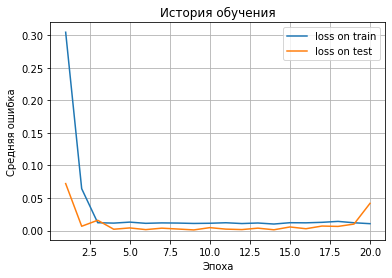

In [ ]:
history = model.fit(xTrain, yTrain, epochs=20, batch_size=10, validation_split=0.1)
lh.append(history)
lh.plot()

In [ ]:
score = model.evaluate(xTest, yTest)
score

4/4 [==============================] - 0s 61ms/step - loss: 0.1149 - dice_coef: 0.9831


[0.11490124464035034, 0.9830517768859863]

In [ ]:
pred = model.predict(xTest)

In [ ]:
# Подсчитаем, какая часть слов внутреннего романа правильно распознана
count1, count2 = 0, 0
for i in range(100):
    for j in range(pageSize):
        if yTest[i, j] == 1:
            count1 += 1
            if pred[i, j, 0] > 0.5:
                count2 += 1
print(count1, count2, 'correct: %.4f' % (count2/count1))
# Подсчитаем, какая часть основного романа неправильно распознана как внутренний
count1, count2 = 0, 0
for i in range(100):
    for j in range(pageSize):
        if yTest[i, j] == 0:
            count1 += 1
            if pred[i, j, 0] > 0.5:
                count2 += 1
print(count1, count2, 'errors: %.4f' % (count2/count1))


2427 2167 correct: 0.8929
10373 5 errors: 0.0005


### ВЫВОДЫ

Получена достаточно высокая точность классификации отдельных слов - более 89%. Впрочем,
задача не очень сложна, так как действия обоих романов происходит в разных местах и в разные эпохи, в совершенно разной обстановке и с разными персонажами. Контекст (размер "страниц") был выбран достаточно большим (128), что тоже облегчало задачу.

Я попробовал 2 различные модели - U-net и Трансформер  в простейшей конфигурации (1 блок ээнкодера)
Трансформер показал преимущество во всех отношениях - при меньшем числе параметров и меньшем времени обучения выдал более точный результат.